In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, hour, when
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

2023-09-22 11:22:43.984383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-22 11:22:43.984440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
spark = SparkSession.builder.appName("DataModeling").getOrCreate()

In [6]:
%%time
# Read the Parquet file into a DataFrame
df = spark.read.parquet("/user1/data/parquet/*.parquet")

CPU times: user 5.45 ms, sys: 1.51 ms, total: 6.96 ms
Wall time: 8.89 s


In [7]:
df.show(3, truncate=False)

+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
|square_id|timestamp          |country_code|internet_traffic_activity|hourly_timestamp   |SMS_activity      |call_activity      |weekend_or_weekday|
+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
|1        |2013-10-31 23:00:00|39          |11.028366381681026       |2013-10-31 23:00:00|0.2986512597414538|0.2132127854455914 |weekday           |
|1        |2013-10-31 23:10:00|39          |11.100963451409388       |2013-10-31 23:00:00|0.3983777976024016|0.32241464495433614|weekday           |
|1        |2013-10-31 23:20:00|39          |10.892770602791096       |2013-10-31 23:00:00|0.5015934573020482|0.1887771729145041 |weekday           |
+---------+-------------------+------------+-------------------------+-------------------+----------------

In [8]:
df.printSchema()

root
 |-- square_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = true)



In [12]:
df.count()

7516761

In [13]:
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of distinct rows: 7516761


In [20]:
df.groupby('country_code').count().sort('count').show(30)

+------------+-------+
|country_code|  count|
+------------+-------+
|          45|      1|
|          40|      1|
|         966|      2|
|         421|      2|
|         353|      3|
|         385|      3|
|          61|      4|
|          31|      4|
|         356|      5|
|          90|      6|
|         386|      7|
|         351|      9|
|          43|     14|
|          32|     15|
|         358|     21|
|           0|     21|
|         213|     23|
|          47|     42|
|          34|     68|
|           1|     91|
|         420|     93|
|          48|     98|
|          49|    151|
|          46|    218|
|           7|    496|
|          86|   1054|
|          44|   1197|
|          33|   1298|
|          41|   1353|
|          39|7510461|
+------------+-------+



In [21]:
# numerical stat
df.describe(['internet_traffic_activity', 'SMS_activity', 'call_activity']).show()

+-------+-------------------------+--------------------+--------------------+
|summary|internet_traffic_activity|        SMS_activity|       call_activity|
+-------+-------------------------+--------------------+--------------------+
|  count|                  7516761|             7516761|             7516761|
|   mean|        81.02824368179743|   7.151377454212734|    8.21545912479918|
| stddev|       143.69671563945369|  14.738696897264143|  16.946580289458204|
|    min|     4.792346910579604E-5|1.235047397115846...|4.662995399058662E-6|
|    max|        7936.265379884158|   1211.443277333027|   532.5074148119132|
+-------+-------------------------+--------------------+--------------------+



In [ ]:
df.select(['internet_traffic_activity', 'SMS_activity', 'call_activity']).toPandas().hist()
plt.show()

In [26]:
from pyspark.sql.functions import col

df = df.withColumn("square_id", col("square_id").cast("integer"))

In [27]:
# correlation
features = ['square_id', 'internet_traffic_activity', 'SMS_activity', 'call_activity']
n = len(features)

corr = []

for i in range(0, n):
    temp = [None]*i
    
    for j in range(i, n):
        temp.append(df.corr(features[i], features[j]))
    corr.append(temp)
    
corr

[[1.0, 0.1415706480958958, 0.12647822181687138, 0.12565426847843994],
 [None, 1.0, 0.878947619397343, 0.8444776822637831],
 [None, None, 1.0, 0.8929825876389413],
 [None, None, None, 1.0]]

In [34]:
# transform timestamp into categorical values
from pyspark.sql.functions import hour
from pyspark.sql.functions import udf

df = df.withColumn('hour_of_day', hour(df.timestamp))

def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 15:
        return 'lunch'
    elif 15 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'
    
# Apply the UDF to create a new column with categorical values
categorize_hour_udf = udf(categorize_hour)
df = df.withColumn('time_of_day', categorize_hour_udf(df.hour_of_day))

# Show the transformed DataFrame
df.show()

+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+
|square_id|          timestamp|country_code|internet_traffic_activity|   hourly_timestamp|        SMS_activity|       call_activity|weekend_or_weekday|hour_of_day|time_of_day|
+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+
|        1|2013-10-31 23:00:00|          39|       11.028366381681026|2013-10-31 23:00:00|  0.2986512597414538|  0.2132127854455914|           weekday|         23|      night|
|        1|2013-10-31 23:10:00|          39|       11.100963451409388|2013-10-31 23:00:00|  0.3983777976024016| 0.32241464495433614|           weekday|         23|      night|
|        1|2013-10-31 23:20:00|          39|       10.892770602791096|2013-10-31 23:00:00|  0.5015934573020482|  0.18877

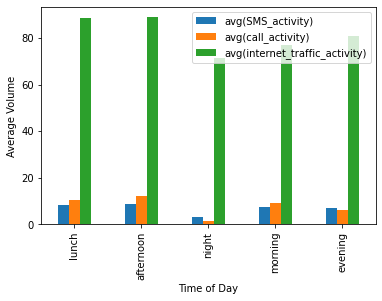

In [35]:
# Group the data by time_of_day and aggregate the average of each activity
activity_by_time_of_day = df.groupBy('time_of_day').agg({'SMS_activity': 'avg', 'call_activity': 'avg', 'internet_traffic_activity': 'avg'})

# Convert the DataFrame to a Pandas DataFrame for plotting
activity_by_time_of_day_pd = activity_by_time_of_day.toPandas()

# Plot the average volume of each activity per time_of_day
activity_by_time_of_day_pd.plot(kind='bar', x='time_of_day', y=['avg(SMS_activity)', 'avg(call_activity)', 'avg(internet_traffic_activity)'])
plt.xlabel('Time of Day')
plt.ylabel('Average Volume')
plt.show()

In [38]:
#preparing for modeling (cat values, scaling, splitting)
# handle categorical values

from pyspark.ml.feature import StringIndexer,OneHotEncoder

indexer1 = StringIndexer(inputCol='weekend_or_weekday', outputCol='weekend_or_weekday_index')
indexed1 = indexer1.fit(df).transform(df)

indexer2 = StringIndexer(inputCol='time_of_day', outputCol='time_of_day_index')
indexed2 = indexer2.fit(indexed1).transform(indexed1)

encoder = OneHotEncoder(inputCols=['weekend_or_weekday_index', 'time_of_day_index'], outputCols=['weekend_or_weekday_encoded', 'time_of_day_encoded'])
encoded = encoder.fit(indexed2).transform(indexed2)

encoded.show()

+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+------------------------+-----------------+--------------------------+-------------------+
|square_id|          timestamp|country_code|internet_traffic_activity|   hourly_timestamp|        SMS_activity|       call_activity|weekend_or_weekday|hour_of_day|time_of_day|weekend_or_weekday_index|time_of_day_index|weekend_or_weekday_encoded|time_of_day_encoded|
+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+------------------------+-----------------+--------------------------+-------------------+
|        1|2013-10-31 23:00:00|          39|       11.028366381681026|2013-10-31 23:00:00|  0.2986512597414538|  0.2132127854455914|           weekday|         23|      night|                     0.0|  

In [39]:
# dropping values not needed for the model
encoded.printSchema()

root
 |-- square_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- weekend_or_weekday_index: double (nullable = false)
 |-- time_of_day_index: double (nullable = false)
 |-- weekend_or_weekday_encoded: vector (nullable = true)
 |-- time_of_day_encoded: vector (nullable = true)



In [41]:
encoded = encoded.drop('timestamp', 'hour_of_day', 'time_of_day', 'weekend_or_weekday', 'weekend_or_weekday_index', 'time_of_day_index', 'hourly_timestamp')

In [44]:
encoded.printSchema()

root
 |-- square_id: integer (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday_encoded: vector (nullable = true)
 |-- time_of_day_encoded: vector (nullable = true)



In [45]:
# data is now ready for the model